## init

In [1]:
# !pip install torch
# !pip install nilearn
# !pip install matplotlib
# !pip install numpy
# !pip install torchsummary

In [2]:
# !pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torch.nn.functional as F

from tqdm.notebook import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting
from torchsummary import summary
from torch.utils.data.dataset import random_split
from torchvision import transforms
import os

In [2]:
!nvidia-smi

Thu Apr 14 17:24:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:0B:00.0 Off |                    0 |
|  0%   90C    P0    81W / 150W |   2937MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A10          Off  | 00000000:84:00.0 Off |                    0 |
|  0%   

In [3]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 23836098560
free     : 20755644416
used     : 3080454144


In [4]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

device = 0

Torch version: 1.11.0+cu113
Using GPU


## loading data

In [5]:
!ls data

# from google.colab import drive
# drive.mount('/content/drive')

labels.npy  tensors.npy


In [6]:
# labels = np.load("/content/drive/MyDrive/anat/labels.npy")
# tensors = np.load("/content/drive/MyDrive/anat/tensors.npy")

labels = np.load("data/labels.npy")
tensors = np.load("data/tensors.npy")

In [7]:
labels.shape, tensors.shape

((1113,), (1113, 58, 70, 58))

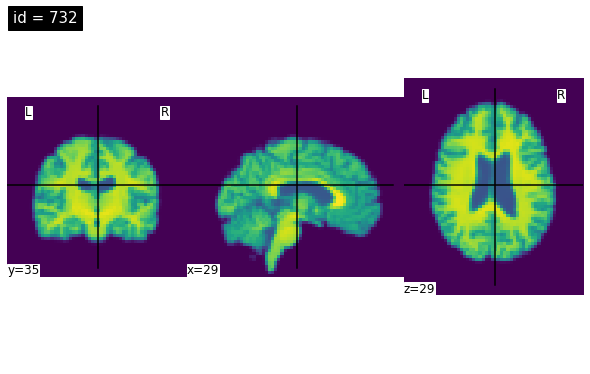

In [8]:
i = random.randint(0, len(tensors) - 1)
t = tensors[i]
tim = nib.Nifti1Image(t, np.diag([1,1,1,1]))
plotting.plot_img(tim, [s / 2 for s in tim.shape], figure=plt.figure(figsize=(8, 5)), title=f'id = {i}');

## preprocessing

In [9]:
def cut_edges(brain):
    return brain[5:-5, 7:-5, 4:-11]

tensors = tensors[:, 5:-5, 7:-5, 4:-11]
tensors.shape

(1113, 48, 58, 43)

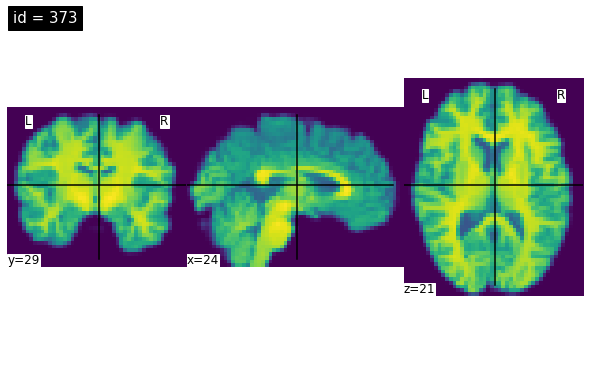

In [10]:
i = random.randint(0, len(tensors) - 1)
t = tensors[i]
tim = nib.Nifti1Image(t, np.diag([1,1,1,1]))
plotting.plot_img(tim, [s / 2 for s in tim.shape], figure=plt.figure(figsize=(8, 5)), title=f'id = {i}');

In [11]:
ds = TensorDataset(torch.Tensor(tensors[:, None]), torch.Tensor(labels))

## models

In [12]:
def display_brain(tensors, i=None, label=None):
    i = random.randint(0, len(tensors) - 1) if i is None else i
    label = f'id = {i}' if label is None else label
    t = tensors[i]
    tim = nib.Nifti1Image(t, np.diag([1,1,1,1]))
    plotting.plot_img(tim, [s / 2 for s in tim.shape], figure=plt.figure(figsize=(8, 5)), title=label);

In [13]:
class VAE3b32ch16f(nn.Module):
    def __init__(self, latent_shape=3360):
        super().__init__()
        
        # encoder:
        
        self.block1 = nn.Sequential(
                nn.Conv3d(1, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))

        self.block2 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.block3 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.pool1 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool2 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool3 = nn.MaxPool3d(2, 2, return_indices=True)
        
        self.feat = nn.Sequential(
                nn.Conv3d(32, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.Conv3d(16, 16, 3, 1, 1),
                nn.Flatten())

        # distrib
        
        self.enc_mu = nn.Linear(3360, latent_shape)
        self.enc_sig = nn.Linear(3360, latent_shape)
        
        # decoder:
        
        self.unflat = nn.Sequential(
                nn.Linear(latent_shape, 3360),
                nn.Unflatten(1, [16, 6, 7, 5]))
        
        self.deblock1 = nn.Sequential(
                nn.ConvTranspose3d(16, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock2 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock3 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.unpool1 = nn.MaxUnpool3d(2, 2)
        self.unpool2 = nn.MaxUnpool3d(2, 2)
        self.unpool3 = nn.MaxUnpool3d(2, 2)
        
        self.reconstruct = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1),
                nn.ReLU(),
                nn.ConvTranspose3d(32, 1, 3, 1, 1))
        
        
    def encode(self, x):
        self.shape1 = x.shape
        x = self.block1(x)
        x, self.ind1 = self.pool1(x)
        
        self.shape2 = x.shape
        x = self.block2(x)
        x, self.ind2 = self.pool2(x)
        
        self.shape3 = x.shape
        x = self.block3(x)
        x, self.ind3 = self.pool3(x)
        
        x = self.feat(x)
        mu, sig = self.enc_mu(x), self.enc_sig(x)
        return mu, sig
    
    def decode(self, mu, sig):
        # temp block
#         std = torch.exp(sig / 2)
#         q = torch.distributions.Normal(mu, std)
#         x = q.rsample()
        # temp block
        epsilon = torch.randn(mu.shape).to(device=device)
        x = mu + epsilon * sig
        
        x = self.unflat(x)
        
        x = self.deblock1(x)
        x = self.unpool1(x, self.ind3, self.shape3)
        
        x = self.deblock2(x)
        x = self.unpool2(x, self.ind2, self.shape2)
        
        x = self.deblock3(x)
        x = self.unpool3(x, self.ind1, self.shape1)
        
        x = self.reconstruct(x)
        return x
    
        
    def forward(self, x):
        mu, sig = self.encode(x)
        x = self.decode(mu, sig)
        return mu, sig, x

In [14]:
# model = VAE3b32ch16f().cuda()
# summary(model, ds[0][0].shape)

In [16]:
np.cumprod(tensors[0].shape)[-1] / 3360

35.628571428571426

In [15]:
def create_stop_crit(buff):
    
    def stop_crit(loss):
        if len(loss) < buff:
            return False
        return np.mean(loss[-buff:]) < loss[-1]
    
    return stop_crit

In [22]:
def vae_train(model, loader, valloader, optimizer, criterion, sched=None, epochs=500, start_e=0, save_n=25,
          stop=(lambda loss:  False), exp_name='undef_exp', folder='unsorted'):

    train_stats = [[],[],[]] # [[rec], [kl], [total]]
    val_stats = [[],[],[]]
    if folder not in os.listdir():
        os.mkdir(folder)
        
        
    # train    
    for e in range(start_e, epochs):
        e_total = 0
        e_kl = 0
        e_rec = 0
        model.train()
        for i, (X, y) in tqdm(enumerate(loader)):
            X = X.cuda()

            mu, sig, outs = model(X)
            rec_loss = criterion(outs, X)
#             KL = torch.mean(-0.5 * torch.sum(1 + sig - mu ** 2 - sig.exp(), dim = 1), dim = 0)
            sig2 = sig ** 2
            KL = torch.mean(-0.5 * torch.sum(1 + torch.log(sig2) - mu**2 - sig2, dim=1),dim=0)
            e_rec += rec_loss
            e_kl += KL
            loss = KL + rec_loss
            e_total += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_stats[0].append(e_rec.item() / len(loader))
        train_stats[1].append(e_kl.item() / len(loader))
        train_stats[2].append(e_total.item() / len(loader))
        
        
        # validate
        model.eval()
        val_rec = 0
        val_kl = 0
        with torch.no_grad():
            for X, y in valloader:
                X = X.cuda()
                mu, sig, outs = model(X)
                val_rec += criterion(outs, X)
                sig2 = sig ** 2
                val_kl += torch.mean(-0.5 * torch.sum(1 + torch.log(sig2) - mu**2 - sig2, dim=1),dim=0)
                
        val_stats[0].append(val_rec.item() / len(valloader))
        val_stats[1].append(val_kl.item() / len(valloader))
        val_stats[2].append((val_rec.item() + val_kl.item()) / len(valloader))
        
        
        # stats + graphs
        clear_output(True)
        print('Epoch', e)
        print(f'Reconstruction loss   Train: {train_stats[0][-1]:.3f} Val:{val_stats[0][-1]:.3f}')
        print(f'KL                    Train: {train_stats[1][-1]:.3f} Val:{val_stats[1][-1]:.3f}')
        print(f'Total loss            Train: {train_stats[2][-1]:.3f} Val:{val_stats[2][-1]:.3f}')
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        show_l = max(0, e - 20)
        ax[0].plot(range(start_e + show_l, e + 1), train_stats[0][show_l:], label='train')
        ax[1].plot(range(start_e + show_l, e + 1), train_stats[1][show_l:], label='train')
        ax[2].plot(range(start_e + show_l, e + 1), train_stats[2][show_l:], label='train')
        ax[0].plot(range(start_e + show_l, e + 1), val_stats[0][show_l:], label='val')
        ax[1].plot(range(start_e + show_l, e + 1), val_stats[1][show_l:], label='val')
        ax[2].plot(range(start_e + show_l, e + 1), val_stats[2][show_l:], label='val')
        ax[0].set_title('Reconstruction')
        ax[1].set_title('KL')
        ax[2].set_title('Total')
        plt.legend();
        
        # scheduler
        if sched:
            sched.step()
        
        # brain image
        t1 = nib.Nifti1Image(X[0][0].detach().cpu().numpy(), np.diag([1, 1, 1, 1]))
        t2 = nib.Nifti1Image(outs[0][0].detach().cpu().numpy(), np.diag([1, 1, 1, 1]))
        f = plt.figure(figsize=(10, 6))
        ax = plt.subplot(2, 1, 1)
        plotting.plot_img(t1, [s / 2 for s in t1.shape], title="Truth", axes=ax)
        ax = plt.subplot(2, 1, 2)
        plotting.plot_img(t2, [s / 2 for s in t2.shape], title="Reconstructed", axes=ax)
        plt.show()

        
        # stops & saves
        if e % save_n == 0:
            torch.save(model.state_dict(), f'{folder + "/" + exp_name + "_"}{start_e + e}')
        if stop(val_stats[2]):
            torch.save(model.state_dict(), f'{folder + "/" + exp_name + "_crit_"}{start_e + e}')
            return

## experiments

### exp 1

first attempt of vae. best (so far) autoencoder's architecture transformed into vae with normal distribution, encoder output size = 3360, means and variances are also 3360 / 2. KL divergence copied from given github. Embedding is 70 times less than original image

Loss = KL + rec_loss

Epoch 25
Reconstruction loss   Train: 4125.587 Val:6012.076
KL                    Train: 132.694 Val:17.265
Total loss            Train: 4258.281 Val:6029.341


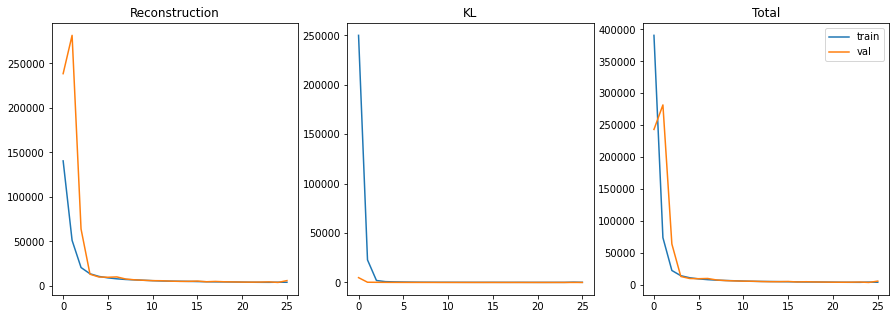

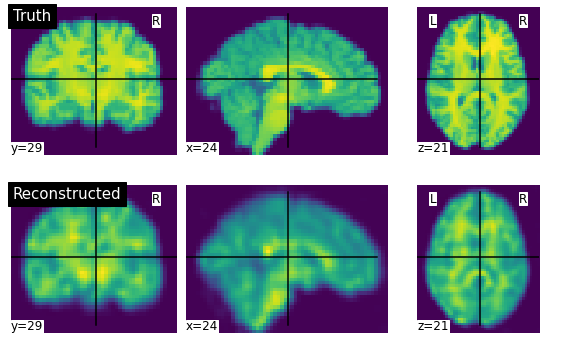

In [23]:
model = VAE3b32ch16f(3360 // 2).cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.01, betas=(0.9, 0.999))
criterion = nn.MSELoss()
stop_crit = create_stop_crit(buff=10)

vae_train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='vae3b32ch16f', folder='vae_exp1')

### exp 2

same architecture, means and vars are 3360 of shape, same as encoder output. Embedding is 35 times less than original image

Epoch 26
Reconstruction loss   Train: 2898.509 Val:3843.675
KL                    Train: 40.780 Val:5.819
Total loss            Train: 2939.290 Val:3849.494


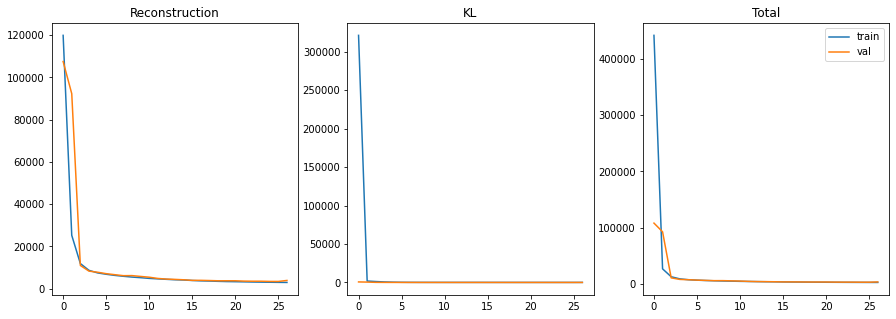

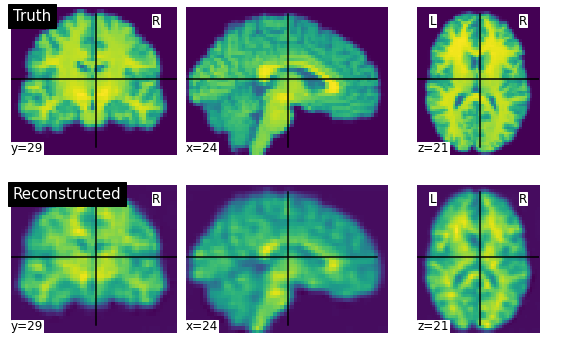

In [24]:
model = VAE3b32ch16f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.01, betas=(0.9, 0.999))
criterion = nn.MSELoss()
stop_crit = create_stop_crit(buff=10)

vae_train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='vae3b32ch16f', folder='vae_exp1')

Epoch 46
Reconstruction loss   Train: 2188.405 Val:2673.717
KL                    Train: 82.847 Val:22.948
Total loss            Train: 2271.252 Val:2696.665


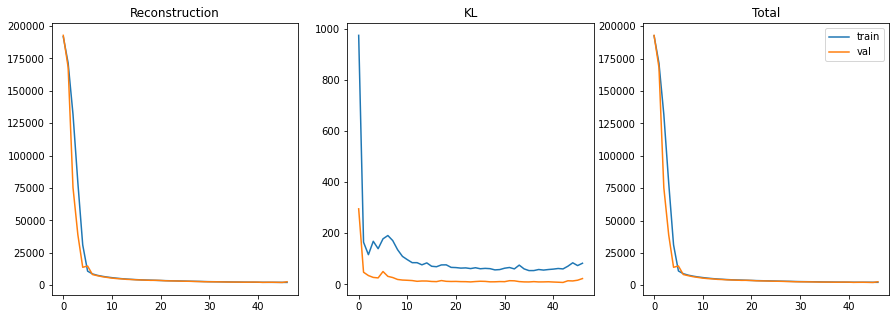

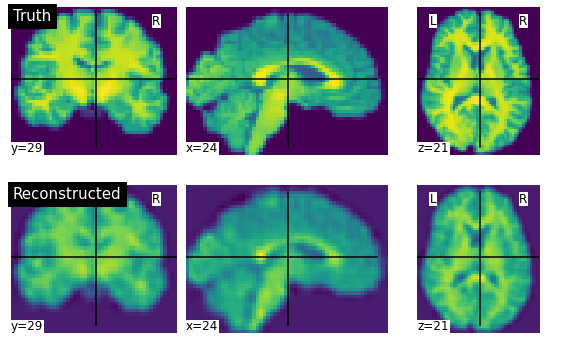

In [26]:
model = VAE3b32ch16f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.001, betas=(0.888, 0.999))
criterion = nn.MSELoss()
stop_crit = create_stop_crit(buff=10)

vae_train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='vae3b32ch16f', folder='vae_exp1')

### exp 3 
from this point we use only normalized data!

In [20]:
model = VAE3b32ch16f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(norm(torch.Tensor(tensors[:, None])), torch.Tensor(labels))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.001, betas=(0.888, 0.999))
criterion = nn.MSELoss()
stop_crit = create_stop_crit(buff=10)

vae_train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='vae3b32ch16f', folder='vae_exp3')

KeyboardInterrupt: 

### exp 4
same model, experimenting with hyperparams

Epoch 87
Reconstruction loss   Train: 0.020 Val:0.079
KL                    Train: 0.018 Val:0.017
Total loss            Train: 0.038 Val:0.096


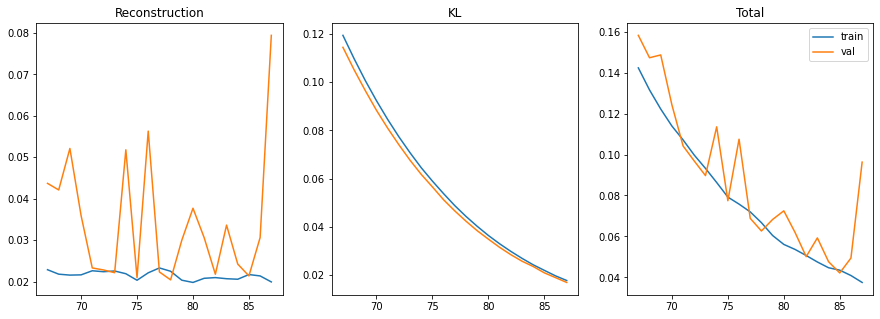

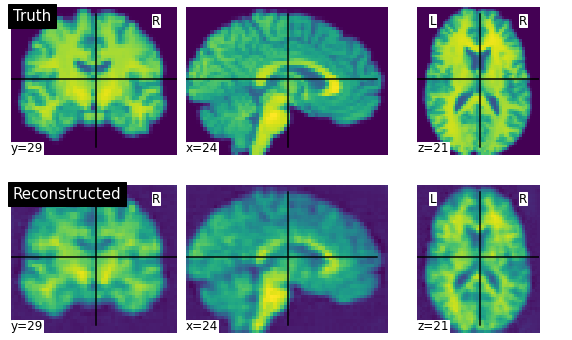

In [23]:
model = VAE3b32ch16f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(norm(torch.Tensor(tensors[:, None])), torch.Tensor(labels))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.01, betas=(0.888, 0.999), weight_decay=1e-3)
lambda1 = lambda epoch: 0.85 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
criterion = nn.MSELoss()
stop_crit = create_stop_crit(buff=10)

vae_train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='vae3b32ch16f', folder='vae_exp4')